<a href="https://colab.research.google.com/github/adnanfathoni88/Sawit-Transformer/blob/main/sawit_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

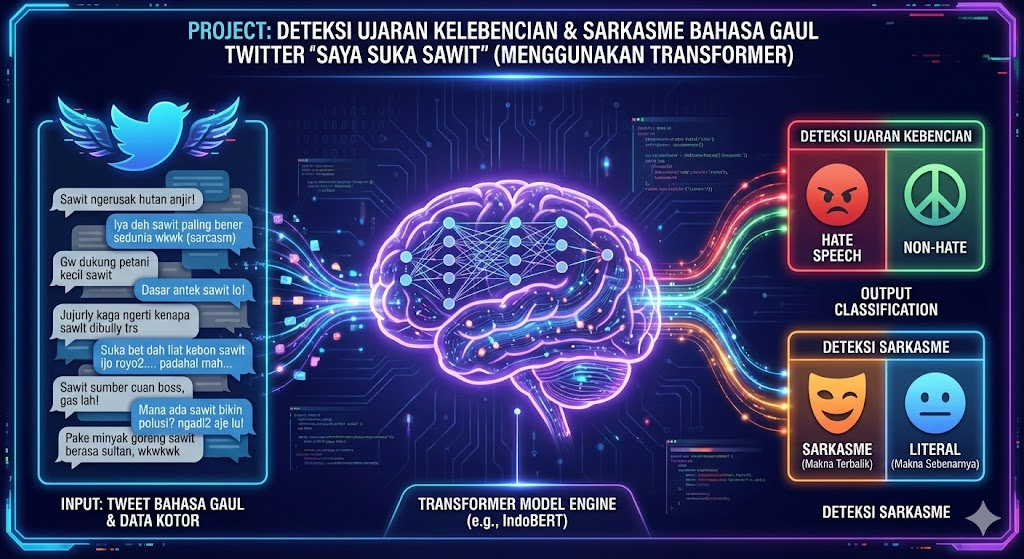

In [ ]:
!pip install transformers[torch] datasets scikit-learn pandas accelerate -U

In [ ]:
!pip install -q datasets huggingface_hub

In [ ]:
from huggingface_hub import login

login(token="xxxx")

In [ ]:
from datasets import load_dataset
import pandas as pd

# dataset dari huggingface
hate_ds = load_dataset("haipradana/indonesian-twitter-hate-speech-cleaned")
sarcasm_ds = load_dataset("w11wo/twitter_indonesia_sarcastic")

# ubah menjadi pd
hate_df = pd.concat(
    [hate_ds[split].to_pandas() for split in hate_ds.keys()],
    ignore_index=True
)
sarcasm_df = pd.concat(
    [sarcasm_ds[split].to_pandas() for split in sarcasm_ds.keys()],
    ignore_index=True
)


# merubah label hate_ds dari hate/neutral menjadi 1/0
hate_df["label_3class"] = hate_df["label"].str.strip().map({
    "neutral": 0,
    "hate": 1
})
hate_df = hate_df[["text", "label_3class"]]


# merubah label sarcasm dari 0/1 menjadi 0/2 karena 3 label jadi 2 = sarkas
sarcasm_df["label_3class"] = sarcasm_df["label"].apply(
    lambda x: 2 if x == 1 else 0
)
sarcasm_df = sarcasm_df.rename(columns={"tweet": "text"})
sarcasm_df = sarcasm_df[["text", "label_3class"]]

combined = pd.concat(
    [hate_df, sarcasm_df],
    ignore_index=True
)
combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)

print("Jumlah data per label:")
print(combined["label_3class"].value_counts())

# final dataframe
df = combined

Jumlah data per label:
label_3class
0    10936
1     9225
2      671
Name: count, dtype: int64


In [ ]:
# Load dataset
path = 'https://drive.google.com/file/d/1kCsgN2YUPlLTMpmrvq2hxKXCK-Paxexn/view?usp=sharing'
file_id=path.split('/')[-2]
url='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(url)
df.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,"Selamat ulang tahun kakak tulus semoga panjang umur kakak,sehat selalu juga,murah rezeki ya kakak dan jangan sombong kalo sukses di karirnya aminn @tulusm",elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @tulusm,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @tulusm,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [ ]:
import pandas as pd
import re
from sklearn.utils import resample

# Load real colloquial lexicon
lexicon_df = pd.read_csv(url)

# slang -> formal dict
norm_dict = dict(zip(lexicon_df["slang"], lexicon_df["formal"]))

def normalize_text(text):
    tokens = re.findall(r"\w+|\S", text)
    return " ".join([norm_dict.get(t.lower(), t) for t in tokens])

emoji_map = {
    "😂": " EMOJI_LAUGH ",
    "🤣": " EMOJI_LAUGH ",
    "😡": " EMOJI_ANGRY ",
    "😠": " EMOJI_ANGRY ",
    "😢": " EMOJI_SAD ",
    "😏": " EMOJI_SARCASTIC ",
    "🙄": " EMOJI_ROLL_EYES ",
    "😭": " EMOJI_SAD ",
    "😆": " EMOJI_LAUGH "
}

# cleaning
def clean_text(text):
    text = str(text)

    # hapus url
    text = re.sub(r"http\S+|www\S+", "", text)

    # hapus mention
    text = re.sub(r"@\w+", "", text)

    # hapus hashtag(#)
    text = text.replace("#", "")

    # map emoji ke token
    for emo, token in emoji_map.items():
        text = text.replace(emo, token)

    # normalize slang
    text = normalize_text(text)

    # normalize karakter panjang (anjiiinggg -> anjing)
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # normalize punctuation (!!! -> !)
    text = re.sub(r"([!?]){2,}", r"\1", text)

    # hapus spasi berlebih
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Ensure df refers to the combined (tweet) dataframe from the previous cell
df = combined
df["clean_text"] = df["text"].apply(clean_text)


# balancing dataset (upsampling) supaya tidak cenderung ke netral

# Pisahkan per kelas
df_0 = df[df["label_3class"] == 0]
df_1 = df[df["label_3class"] == 1]
df_2 = df[df["label_3class"] == 2]

# target = kelas terbesar
max_size = max(len(df_0), len(df_1), len(df_2))

df_0_bal = resample(df_0, replace=True, n_samples=max_size, random_state=42)
df_1_bal = resample(df_1, replace=True, n_samples=max_size, random_state=42)
df_2_bal = resample(df_2, replace=True, n_samples=max_size, random_state=42)

# gabung & shuffle
df_balanced = pd.concat(
    [df_0_bal, df_1_bal, df_2_bal]
).sample(frac=1, random_state=42).reset_index(drop=True)

pd.set_option("display.max_colwidth", None)

print("Distribusi label setelah balancing:")
print(df_balanced["label_3class"].value_counts())

print("\nSample data:")
print(df_balanced[["text", "clean_text", "label_3class"]].head())

Distribusi label setelah balancing:
label_3class
1    10936
2    10936
0    10936
Name: count, dtype: int64

Sample data:
                                                                                                                                                                                            text  \
0                                                                                        Liat orang lagi sulit bisa bisanya gamau bantu, liat ntar pas lu susah gaada yang bantu mampus lu tai.'   
1                                                                         WOW . Setelah tidak bisa buka salak akhirnya bisa setrika baju . Berita yang sangat tidak berfaedah sekali . <hashtag>   
2                                                                                                                           Contoh nya DKI impor bawang dari cina.gubernur nya kroni si tengku.'   
3                                                                                dia kira masy

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Cukup gunakan dataset asli (combined), jangan gunakan resample/upsampling
df = combined
df["clean_text"] = df["text"].apply(clean_text)

# Split 80% train 20% test dengan 'stratify' agar distribusi label tetap adil
from sklearn.model_selection import train_test_split

X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    df['clean_text'],
    df['label_3class'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_3class']
)

# Konversi ke list agar bisa diproses Dataset class
X_train = X_train_raw.tolist()
X_val = X_val_raw.tolist()
y_train = y_train_raw.tolist()
y_val = y_val_raw.tolist()

# model yang digunakan = indolem/indobertweet-base-uncased dikarenakan sangat kuat utk slang, bhs gaul, sarkas, ujaran kebencian
MODEL_NAME = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # tokenisasi teks
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=64, # Sesuaikan panjang tweet, 64-128 biasanya cukup
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

# Buat objek dataset
train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)

print("Dataset siap! Jumlah data latih:", len(train_dataset))


Dataset siap! Jumlah data latih: 16665


In [ ]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers import Trainer, AutoModelForSequenceClassification, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

# Hitung weights berdasarkan label di training set
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Ubah ke tensor untuk PyTorch
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print(f"Weights per kelas (0, 1, 2): {weights}")

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Inisialisasi Loss Function dengan weights
        # Pastikan class_weights sudah dipindahkan ke device yang sama (GPU/CPU)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# 1. Load Model Pre-trained
# num_labels=2 artinya Binary Classification (0 atau 1)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# 2. Fungsi untuk Menghitung Akurasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }

# 3. Training Arguments (Pengaturan Latihan)
training_args = TrainingArguments(
    output_dir='./results',          # Folder output
    num_train_epochs=3,              # Jumlah putaran latihan (3-5 sudah cukup biasanya)
    per_device_train_batch_size=8,   # Jika GPU error 'Out of Memory', kecilkan jadi 4
    per_device_eval_batch_size=16,
    warmup_steps=100,                # Pemanasan learning rate
    weight_decay=0.01,
    warmup_ratio=0.1,
    metric_for_best_model="f1_macro",
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",     # Evaluasi setiap akhir epoch
    save_strategy="epoch",
    load_best_model_at_end=True,      # Simpan model terbaik, bukan yang terakhir
    report_to="none"
)

# 4. Inisialisasi Trainer
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# 5. MULAI TRAINING! 🚀
trainer.train()

Weights per kelas (0, 1, 2): [ 0.63500229  0.75271003 10.34450652]


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indolem/indobertweet-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is depre

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.960242,0.555103,0.802976,0.706159,0.805684
2,0.269358,0.675171,0.822654,0.745689,0.822229
3,0.222241,0.791625,0.823134,0.748400,0.823265


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=6252, training_loss=0.4946117935677179, metrics={'train_runtime': 774.4906, 'train_samples_per_second': 64.552, 'train_steps_per_second': 8.072, 'total_flos': 1644294414913920.0, 'train_loss': 0.4946117935677179, 'epoch': 3.0})

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

label_map = {
    0: "Netral",
    1: "Hate Speech",
    2: "Sarkasme"
}

def predict_text(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]

    pred_label = torch.argmax(probs).item()

    print(f"Teks      : {text}")
    print(f"Prediksi  : {label_map[pred_label]}")
    print("Probabilitas:")
    for i, label in label_map.items():
        print(f"  - {label:12}: {probs[i].item():.4f}")
    print("-" * 50)

print("=== HASIL PENGUJIAN MANUAL ===")
predict_text("Sawit membuka lapangan kerja untuk rakyat.")
predict_text("Bagus banget ya hutannya jadi gundul semua, makasih investor! 👏")
predict_text("Hancurkan saja semua kebun sawit itu!")
predict_text("Semoga sawitku cepat berbuah menjadi uang xixi")

=== HASIL PENGUJIAN MANUAL ===
Teks      : Sawit membuka lapangan kerja untuk rakyat.
Prediksi  : Netral
Probabilitas:
  - Netral      : 0.9870
  - Hate Speech : 0.0057
  - Sarkasme    : 0.0074
--------------------------------------------------
Teks      : Bagus banget ya hutannya jadi gundul semua, makasih investor! 👏
Prediksi  : Hate Speech
Probabilitas:
  - Netral      : 0.1889
  - Hate Speech : 0.7066
  - Sarkasme    : 0.1045
--------------------------------------------------
Teks      : Hancurkan saja semua kebun sawit itu!
Prediksi  : Hate Speech
Probabilitas:
  - Netral      : 0.0014
  - Hate Speech : 0.9984
  - Sarkasme    : 0.0002
--------------------------------------------------
Teks      : Semoga sawitku cepat berbuah menjadi uang xixi
Prediksi  : Netral
Probabilitas:
  - Netral      : 0.9977
  - Hate Speech : 0.0010
  - Sarkasme    : 0.0013
--------------------------------------------------
